# Classifying near-Antarctic profiles

## Initial setup

### Load modules

In [1]:
# modules in this package
import load_and_preprocess as lp
import analysis as at
import bic_and_aic as ba
import plot_tools as pt
import file_io as io
import numpy as np
import xarray
import density
import gmm
# plotting tools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl
import cmocean
import cartopy.crs as ccrs
# os tools
import os.path

# suppress a particular warning
import warnings
warnings.filterwarnings('ignore', 'RuntimeWarning: All-NaN slice encountered')

### Set runtime parameters (file locations, etc.)

In [2]:
# set locations and names
descrip = 'WeddellOnly' # extra description for filename
data_location = '../../so-chic-data/' # input data location
classified_data_location = 'models/profiles_-65to80lon_-85to-30lat_20to1000depth_5K_allDomain_revised.nc'
ploc = 'plots/plots_WeddellClassOnly_top1000m_K03_forPaper/'
#ploc = 'tests/'
dloc = 'models/'

# if plot directory doesn't exist, create it
if not os.path.exists(ploc):
    os.makedirs(ploc)

# single class from previous effort to sub-classify
# don't forget 0 indexing
myClass=1

# calculate BIC and AIC? set max number of components
getBIC = False
max_N = 20

# save the processed output as a NetCDF file?
saveOutput = True

# number of PCA components (roughly 95%)
n_pca = 6

# make decision about n_components_selected (iterative part of analysis)
n_components_selected = 3

#longitude and latitude range
lon_min = -65
lon_max =  80
lat_min = -80
lat_max = -45
# depth range
zmin = 20.0
zmax = 1000.0
# density range
sig0range = (26.6, 28.0)

# temperature and salinity ranges for plotting
lon_range=(lon_min, lon_max)
lat_range=(lat_min, lat_max)
Trange=(-2.2, 6.0)
Srange=(33.5, 35.0)

# create filename for saving GMM and saving labelled profiles
pca_fname = dloc + 'pca_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + 'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + str(int(n_pca)) + descrip
gmm_fname = dloc + 'gmm_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + 'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + str(int(n_components_selected)) + 'K_' + descrip
fname = dloc + 'profiles_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + 'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + str(int(n_components_selected)) + 'K_' + descrip + '.nc'

# colormap
colormap = plt.get_cmap('Dark2', n_components_selected)
colormap_cividis = plt.get_cmap('cividis', 20)

### Load profile data from the Antarctic class (identified in notebook: 1_profile_distribution.ipynb)

load_and_preprocess.load_single_class
----> single-class profiles loaded
plot_tools.plot_profiles


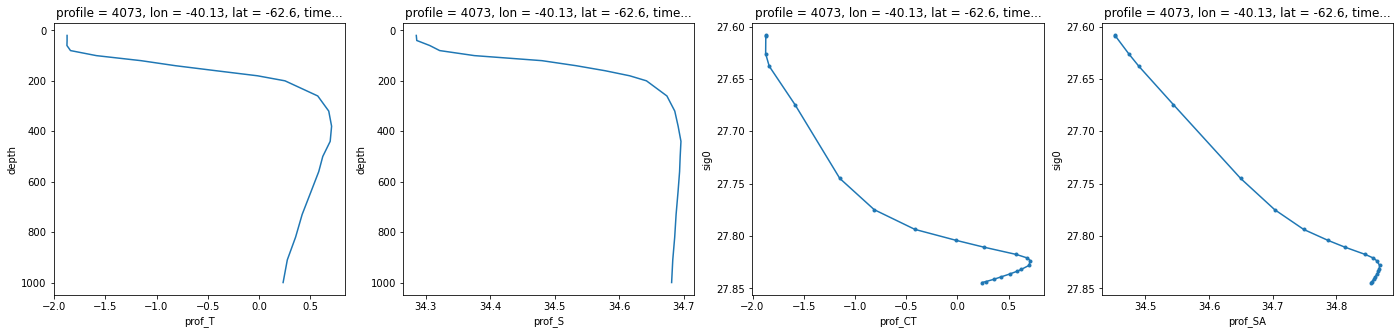

In [28]:
# load single class (just the Weddell One)
profiles = lp.load_single_class(classified_data_location, selected_class=myClass)

# plot random profile
pt.plot_profile(ploc, profiles.isel(profile=1400))

In [40]:
profiles

<xarray.Dataset>
Dimensions:        (profile: 28397, depth: 21, depth_highz: 50, sig0_levs: 100)
Coordinates:
  * profile        (profile) int64 13 14 15 16 ... 142282 142301 142320 142330
    lon            (profile) float64 -26.44 -22.37 -17.38 ... 53.09 53.33 53.76
    lat            (profile) float64 -55.98 -56.81 -57.51 ... -58.46 -58.59
  * depth          (depth) float64 20.0 40.0 60.0 80.0 ... 820.0 910.0 1e+03
    time           (profile) datetime64[ns] 1973-01-11T12:00:00 ... 2020-10-1...
    year           (profile) int64 1973 1973 1973 1973 ... 2020 2020 2020 2020
    month          (profile) int64 1 1 1 1 1 1 1 1 1 1 ... 8 8 8 9 9 9 9 9 10 10
  * depth_highz    (depth_highz) float64 20.0 40.0 60.0 ... 960.0 980.0 1e+03
  * sig0_levs      (sig0_levs) float64 22.66 22.72 22.77 ... 27.86 27.91 27.97
Data variables: (12/13)
    prof_date      (profile) float64 7.206e+05 7.206e+05 ... 7.381e+05 7.381e+05
    prof_YYYYMMDD  (profile) float64 1.973e+07 1.973e+07 ... 2.02e+07 2.02e+07
    prof_HHMMSS    (profile) float64 1.2e+05 1.2e+05 ... 4.45e+04 5.19e+04
    prof_T         (profile, depth) float64 ...
    prof_S         (profile, depth) float64 ...
    sig0           (profile, depth) float64 ...
    ...             ...
    prof_CT        (profile, depth) float64 ...
    ct_on_highz    (profile, depth_highz) float64 ...
    sa_on_highz    (profile, depth_highz) float64 ...
    sig0_on_highz  (profile, depth_highz) float64 ...
    ct_on_sig0     (profile, sig0_levs) float64 ...
    sa_on_sig0     (profile, sig0_levs) float64 ...

In [128]:
import random

# single-profile Dataset that will be merged with others to form the training Dataset
training_dataset = profiles.isel(profile=[0,1])

# define the grid spacing and the lat/lon values of the sampling grid
grid_spacing = 10.0
max_number_of_samples_from_a_cell = 500
i_sampling_grid = np.arange(lon_min, lon_max, grid_spacing)
j_sampling_grid = np.arange(lat_min, lat_max, grid_spacing)

# loop through each cell in the sampling grid
for i in i_sampling_grid:
    for j in j_sampling_grid:
        
        # define the lat-lon edges of the sampling grid cell
        is_in_cell_lon = ( profiles.lon > i ) & ( profiles.lon <= i + grid_spacing )
        is_in_cell_lat = ( profiles.lat > j ) & ( profiles.lat <= j + grid_spacing )
        
        # find all the profiles that are in the selected sampling grid cell
        profiles_in_cell_lon = profiles.where(is_in_cell_lon, drop=True)
        profiles_in_cell_latlon = profiles_in_cell_lon.where(is_in_cell_lat, drop=True)
        
        # maximum number of profiles that can be sampled in the selected sampling grid cell
        max_number_of_profiles = profiles_in_cell_latlon.profile.size
        
        # scale the max number of samples from a cell by the cosine of latitude
        lat_scaling = np.cos(j*np.pi/180 - lat_max)
        max_number_of_samples_from_a_cell_scaled = round(max_number_of_samples_from_a_cell*lat_scaling)
        
        # select random subset of the profiles in the sampling grid cell
        if max_number_of_profiles>0:
            # the number of samples should be all the profiles, or the max number, whichever is smaller
            number_of_samples = np.minimum(max_number_of_profiles, max_number_of_samples_from_a_cell_scaled)
            # next, find the indices for the random samples
            indices_for_random_samples = random.sample(range(0,max_number_of_profiles), number_of_samples)
            drawn_from_sampling_cell = profiles_in_cell_latlon.isel(profile=indices_for_random_samples)
            
            # merge the profiles drawn from the sampling cell with the rest of the training dataset
            training_dataset = training_dataset.merge(drawn_from_sampling_cell)
        
# show results
training_dataset
            

<xarray.Dataset>
Dimensions:        (profile: 13873, depth: 21, depth_highz: 50, sig0_levs: 100)
Coordinates:
  * profile        (profile) int64 13 14 17 19 ... 142240 142275 142320 142330
    lon            (profile) float64 -26.44 -22.37 -14.53 ... 40.24 53.33 53.76
    lat            (profile) float64 -55.98 -56.81 -57.87 ... -58.46 -58.59
  * depth          (depth) float64 20.0 40.0 60.0 80.0 ... 820.0 910.0 1e+03
    time           (profile) datetime64[ns] 1973-01-11T12:00:00 ... 2020-10-1...
    year           (profile) float64 1.973e+03 1.973e+03 ... 2.02e+03 2.02e+03
    month          (profile) float64 1.0 1.0 1.0 1.0 1.0 ... 8.0 9.0 10.0 10.0
  * depth_highz    (depth_highz) float64 20.0 40.0 60.0 ... 960.0 980.0 1e+03
  * sig0_levs      (sig0_levs) float64 22.66 22.72 22.77 ... 27.86 27.91 27.97
Data variables: (12/13)
    prof_date      (profile) float64 7.206e+05 7.206e+05 ... 7.381e+05 7.381e+05
    prof_YYYYMMDD  (profile) float64 1.973e+07 1.973e+07 ... 2.02e+07 2.02e+07
    prof_HHMMSS    (profile) float64 1.2e+05 1.2e+05 ... 4.45e+04 5.19e+04
    prof_T         (profile, depth) float64 -0.1995 -0.878 ... 1.536 1.466
    prof_S         (profile, depth) float64 33.42 33.66 34.03 ... 34.73 34.73
    sig0           (profile, depth) float64 26.84 27.07 27.39 ... 27.8 27.8
    ...             ...
    prof_CT        (profile, depth) float64 -0.1931 -0.8729 ... 1.535 1.466
    ct_on_highz    (profile, depth_highz) float64 -0.1931 -0.8729 ... 1.466
    sa_on_highz    (profile, depth_highz) float64 33.58 33.82 ... 34.9 34.9
    sig0_on_highz  (profile, depth_highz) float64 26.84 27.07 ... 27.8 27.8
    ct_on_sig0     (profile, sig0_levs) float64 nan nan nan nan ... nan nan nan
    sa_on_sig0     (profile, sig0_levs) float64 nan nan nan nan ... nan nan nan

In [129]:
lat_max

-45